In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

In [2]:
df = pd.read_csv("./../churn_data.csv")

# df = pd.get_dummies(df, columns=['internationalplan', 'voicemailplan'], prefix = ['internationalplan', 'voicemailplan'])
df = df.dropna()

df['churn'] = df['churn'].map({'No': 0, 'Yes': 1})

X = df.drop('internationalplan', axis=1)
X = X.drop('voicemailplan', axis=1)
X = X.drop('churn', axis=1).to_numpy()
y = df.loc[:, 'churn'].to_numpy()
count_no = np.sum(y == 0)
count_yes = np.sum(y == 1)
print(f"Array before: yes {count_yes}, no {count_no}")

# Balancing the classes
sm = ClusterCentroids(random_state=42)

X, y = sm.fit_resample(X, y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

count_no = np.sum(y == 0)
count_yes = np.sum(y == 1)
print(f"Array after: yes {count_yes}, no {count_no}")

Array before: yes 590, no 3617


/home/diogo/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f900a767b80>
Traceback (most recent call last):
  File "/home/diogo/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/diogo/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/diogo/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/diogo/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 64

Array after: yes 590, no 590


In [3]:
def evaluate(model, model_name):
    predictions = model.predict(Xtest)

    cm = metrics.confusion_matrix(ytest, predictions)

    tp = cm[1][1]
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    total = tp + tn + fp + fn
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)

    print(f"{model_name} Kernel SVM:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    print(f"Accuracy: {(tp+tn)/total}")
    print(f"Error: {1-(tp+tn)/total}")
    print(f"Recall: {recall}")
    print(f"Specificity: {tn/(tn+fp)}")
    print(f"Precision: {precision}")
    print(f"F1: {2*recall*precision/(recall+precision)}")


In [35]:
svmLinear = SVC(kernel='linear', C=100)
svmLinear.fit(Xtrain, ytrain)

SVC(C=100, kernel='linear')

In [38]:
evaluate(svmLinear, "Linear")

Linear Kernel SVM:
TP: 84, TN: 93, FP: 22, FN: 37
Accuracy: 0.75
Error: 0.25
Recall: 0.6942148760330579
Specificity: 0.808695652173913
Precision: 0.7924528301886793
F1: 0.7400881057268722


In [4]:
svmPoly = SVC(kernel='poly', C=100)
svmPoly.fit(Xtrain, ytrain)

SVC(C=100, kernel='poly')

In [5]:
evaluate(svmPoly, "Polinomial")

Polinomial Kernel SVM:
TP: 84, TN: 105, FP: 10, FN: 37
Accuracy: 0.8008474576271186
Error: 0.19915254237288138
Recall: 0.6942148760330579
Specificity: 0.9130434782608695
Precision: 0.8936170212765957
F1: 0.7813953488372092


In [6]:
svmRBF = SVC(kernel='rbf', C=100)
svmRBF.fit(Xtrain, ytrain)

SVC(C=100)

In [7]:
evaluate(svmRBF, "RBF")

RBF Kernel SVM:
TP: 79, TN: 110, FP: 5, FN: 42
Accuracy: 0.8008474576271186
Error: 0.19915254237288138
Recall: 0.6528925619834711
Specificity: 0.9565217391304348
Precision: 0.9404761904761905
F1: 0.7707317073170733


In [8]:
svmSigmoid = SVC(kernel="sigmoid", C=100)
svmSigmoid.fit(Xtrain, ytrain)

SVC(C=100, kernel='sigmoid')

In [9]:
evaluate(svmSigmoid, "Sigmoid")

Sigmoid Kernel SVM:
TP: 60, TN: 70, FP: 45, FN: 61
Accuracy: 0.5508474576271186
Error: 0.4491525423728814
Recall: 0.49586776859504134
Specificity: 0.6086956521739131
Precision: 0.5714285714285714
F1: 0.5309734513274337


In [36]:
def recall_testing(kernel, n):
    recalls = [0] * n

    for i in range(1, n):
        svmPoly = SVC(kernel=kernel, C=i)
        svmPoly.fit(Xtrain, ytrain)

        predictions = svmPoly.predict(Xtest)
        recall = metrics.recall_score(ytest, predictions)

        recalls[i] = recall

    plt.scatter(list(range(1, n)), recalls[1:])

    plt.xlabel('C')
    plt.ylabel('Recall')

    plt.title(f'Relation between hyperparameter C and Recall for {kernel}')
    plt.show()


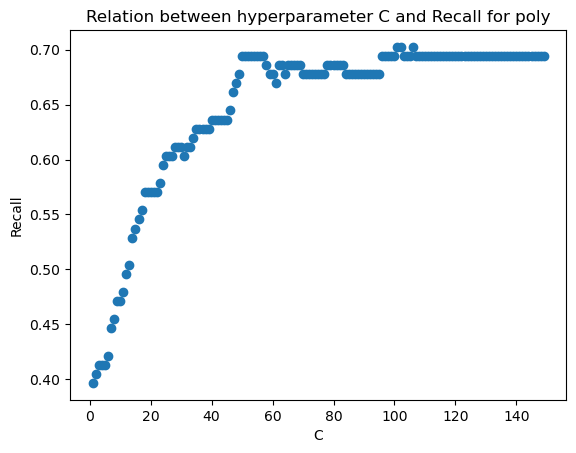

In [32]:
recall_testing('poly', 150)

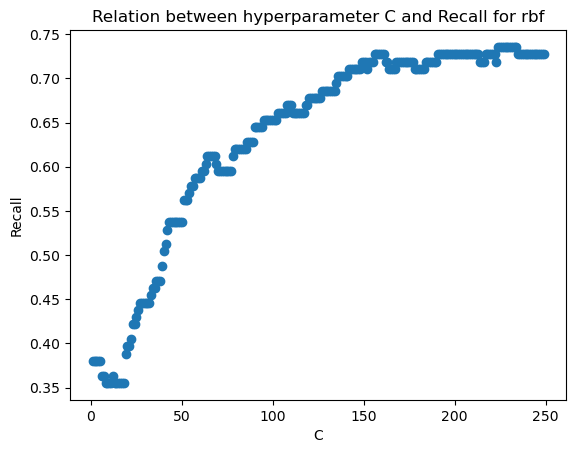

In [38]:
recall_testing('rbf', 250)

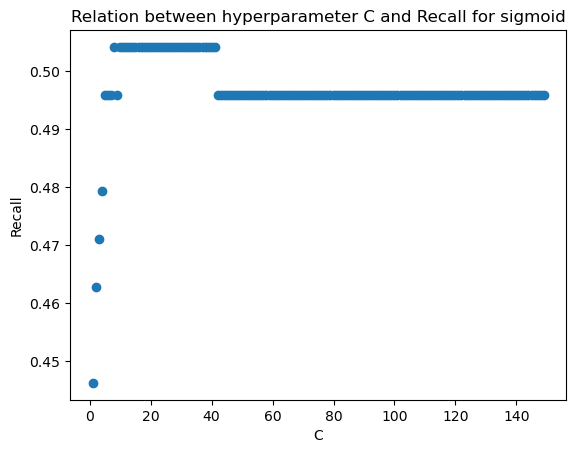

In [33]:
recall_testing('sigmoid', 150)

In [22]:
def cvSVM(kernel, n):
    recalls = [0] * len([*range(50, n + 1, 10)])
    std = [0] * len([*range(50, n + 1, 10)])
    j = 0
    for i in range(50, n +1, 10):
        svm = SVC(kernel=kernel, C=i)
        scores=cross_val_score(svm, Xtrain, ytrain, cv=10, scoring='recall')

        std[j] = scores.std()
        recalls[j] = scores.mean()
        j+=1

    print(f"Standard Deviations: {std}")
    plt.scatter(list(range(50, n+1, 10)), recalls)

    plt.xlabel('C')
    plt.ylabel('Recall')

    plt.title(f'Relation between hyperparameter C and Recall for {kernel}')
    plt.show()
    

Standard Deviations: [0.07209550930324536, 0.06758898054719932, 0.06606331342901405, 0.06669783910892754, 0.0649455530930845, 0.07173410530099666, 0.06958225281996566, 0.06042496613573322, 0.05387566266856627, 0.05902529847049916, 0.06434855020634038, 0.06434855020634038, 0.06681551746006878, 0.06203788667627673, 0.05941084798859996, 0.06223704612014301, 0.06029666157194167, 0.06029666157194167]


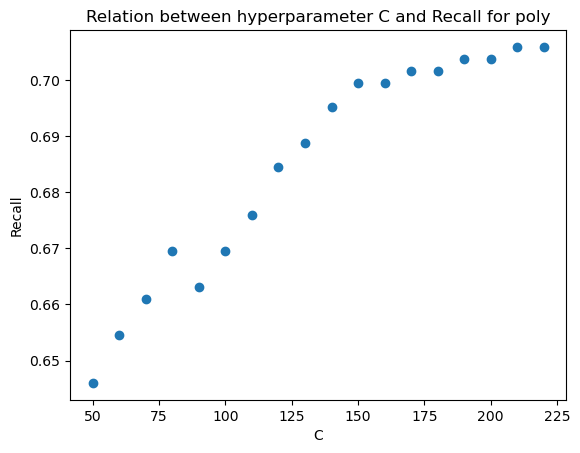

In [23]:
cvSVM('poly', n=220)

Standard Deviations: [0.0654123485932447, 0.0642433211601138, 0.0708696280076099, 0.07033996965048528, 0.06593481894766093, 0.06940369630008264, 0.06667876734720855, 0.06163524231594672, 0.05688055965363615, 0.05965343807314751, 0.060407544059027596, 0.060407544059027596, 0.06032929522353913, 0.061055717899283206, 0.061055717899283206, 0.061055717899283206, 0.061700272638742115, 0.058708918021309925]


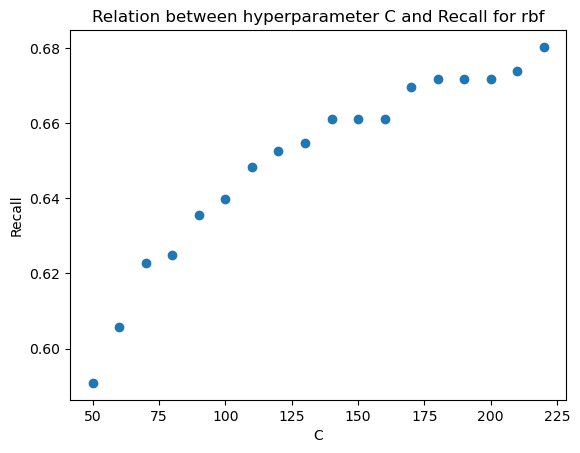

In [24]:
cvSVM('rbf', n = 220)

Standard Deviations: [0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933, 0.05452593485190933]


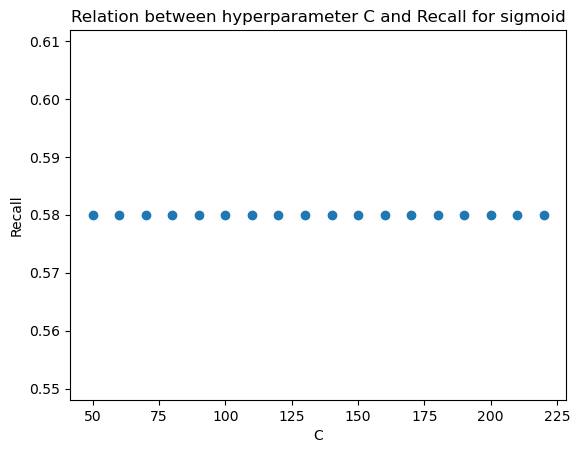

In [25]:
cvSVM('sigmoid', n = 220)

In [30]:
# Best Results: C=170, kernel='poly'

svmPoly = SVC(kernel='poly', C=170)
svmPoly.fit(Xtrain, ytrain)

SVC(C=170, kernel='poly')

In [31]:
evaluate(svmPoly, 'polynomial')

polynomial Kernel SVM:
TP: 86, TN: 105, FP: 10, FN: 35
Accuracy: 0.809322033898305
Error: 0.19067796610169496
Recall: 0.7107438016528925
Specificity: 0.9130434782608695
Precision: 0.8958333333333334
F1: 0.7926267281105991
